## Overview

This project focuses on classifying the Iris dataset's three species (Setosa, Versicolor, Virginica) using machine learning. After testing several algorithms, including support vector machines and k-nearest neighbors, the best-performing model was selected based on accuracy, precision, recall, and F1-score. Hyperparameter tuning and cross-validation ensured robust classification performance, with the final model achieving high accuracy on unseen test data.

## Import Libraries

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from xgboost import XGBClassifier  # Import the correct class
from scikeras.wrappers import KerasClassifier

## Load Dataset

In [2]:
# fetching dataset 
iris = fetch_ucirepo(id=53) 

X = iris.data.features 
y = iris.data.targets 

## Dataset Overview

In [3]:
# Basic dataset overview
print("Dataset Overview:")
print(f"Number of observations: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target column: {y.columns[0]}")

Dataset Overview:
Number of observations: 150
Number of features: 4
Feature columns: ['sepal length', 'sepal width', 'petal length', 'petal width']
Target column: class


In [4]:
# Class distribution 
class_counts = y[y.columns[0]].value_counts()
class_proportions = class_counts / y.shape[0]

# printing class distribution 
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} observations ({class_proportions[cls]:.2%})")

Class Distribution:
Class Iris-setosa: 50 observations (33.33%)
Class Iris-versicolor: 50 observations (33.33%)
Class Iris-virginica: 50 observations (33.33%)


In [5]:
# Summary statistics for features
print("Feature Summary Statistics:")
print(X.describe())

Feature Summary Statistics:
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [6]:
# Verifying data types
display(X.dtypes)
display(y.dtypes)

sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
dtype: object

class    object
dtype: object

Findings:
- The dataset contains a total of 150 observations, with an equal distribution across the three classes (50 observations per class)
    - Since the dataset is relatively small, simpler algorithms such as SVM, k-NN, and Naive Bayes may perform better than more complex models
    - Given that the classes are balanced, accuracy is a suitable scoring metric for model evaluation, however, I will also be looking at precision, recall, and F1 scores to gain deeper insights into model performance across different classes 
- There are four feature variables, all continuous: sepal length, sepal width, petal length, and petal width 
- There are no missing values 
- Petal dimensions show a wider range and greater variability compared to sepal dimensions, indicating more diversity in petal sizes among samples
- The relatively close median and mean values for each feature suggest that the distributions might be roughly symmetric, though there could be slight skew due to some minimum and maximum values, particularly for petal length
    - Since the features have different ranges and variability, scaling features may improve the performance of algorithms that rely on distance calculations, such as SVM and k-NN

## Prepare Data

In [7]:
# Changing y to a 1-D array 
y = y.values.ravel()

# Encoding labels to be numerical values 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = pd.Categorical(y_encoded)

In [8]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

I want to ensure that each class is properly represented in the training and testing datasets. 

In [9]:
# Converting y_test to a pandas Series
y_test_series = pd.Series(y_test)

# Calculating category proportions
proportions = y_test_series.value_counts(normalize=True) * 100

for category, proportion in proportions.items():
    print(f"Category {category}: {proportion:.2f}%")

Category 2: 36.67%
Category 0: 33.33%
Category 1: 30.00%


In [10]:
# Converting y_train to a pandas Series
y_train_series = pd.Series(y_train)

# Calculating category proportions
proportions = y_train_series.value_counts(normalize=True) * 100

for category, proportion in proportions.items():
    print(f"Category {category}: {proportion:.2f}%")

Category 1: 34.17%
Category 0: 33.33%
Category 2: 32.50%


## Select Model

For this multi-class classification problem, I will perform cross-validation on several algorithms to establish baseline performance metrics:
- SVM
- Random Forest
- Neural Network
- k-Nearest Neighbours 
- XGBoost
- Gaussian Naive Bayes

This approach will allow me to compare their effectiveness and select the most promising model for further hyperparameter tuning. 

I am building the neural network using the following function. As the iris dataset is relatively simple, with only four input features and three output classes, I am using a simpler architecture. The softmax activation in the output layer is ideal for multi-class classification, and the SparseCategoricalCrossentropy loss function is appropriate for integer-encoded labels. 

In [11]:
# Function to build the Neural Network
def create_neural_network():
    classifier = Sequential([
        Input(shape=(4,)), 
        Dense(5, activation='relu'),
        Dense(3, activation='softmax')  
    ])
    classifier.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer='adam'
    )
    
    return classifier

I decided to include a preprocessing step of scaling to get a better picture of algorithm performance, particularly for algorithms that are sensitive to or can benefit from feature scaling. I am not applying scaling to tree-based models (e.g., Random Forest) or Gaussian Naive Bayes because these algorithms are generally insensitive to feature scale. 

In [12]:
# Creating the pipeline framework
pipe_multimodel = Pipeline([('preprocessing', None),
                            ('classifier', None)])

In [13]:
# Defining grid parameters 
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None]}, 
    {'classifier': [RandomForestClassifier()],'preprocessing': [None]}, 
    {'classifier': [KNeighborsClassifier()], 'preprocessing': [StandardScaler(), None]},
    {'classifier': [KerasClassifier(build_fn=create_neural_network, epochs=100)], 'preprocessing': [StandardScaler(), None]}, 
    {'classifier': [XGBClassifier()], 'preprocessing': [None]}, 
    {'classifier': [GaussianNB()], 'preprocessing': [None]}
]

The scoring metrics I have chosen include accuracy, precision, recall, and F1 score with macro-averaging for the multi-class classification.

In [14]:
# Defining scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro', zero_division=1),
    'recall': make_scorer(recall_score, average='macro', zero_division=1),
    'f1': make_scorer(f1_score, average='macro', zero_division=1)
}

In [15]:
# Conducting grid search cross-validation with 5 folds 
grid = GridSearchCV(pipe_multimodel, param_grid, cv=5,
                          return_train_score=True,
                          n_jobs = -1, scoring=scoring_metrics, refit = False)
grid.fit(X_train,y_train)

# Setting cross-validation results as a DataFrame 
df_results = pd.DataFrame(grid.cv_results_)

# Saving values to a list for each model
results_list = []
for i, row in df_results.iterrows():
    class_dict = {
        'Classifier': type(row['param_classifier']).__name__,
        'Preprocessing': row['param_preprocessing'],
        'Accuracy (cv)': row['mean_test_accuracy'],
        'Precision (cv)': row['mean_test_precision'],
        'Recall (cv)': row['mean_test_recall'],
        'F1 (cv)': row['mean_test_f1']
    }
    results_list.append(class_dict)

# Converting results list into a dataframe to display in a table
df_results_table = pd.DataFrame(results_list)

# Formatting 
df_results_table['Preprocessing'] = df_results_table['Preprocessing'].replace({np.nan: 'None'})
df_results_table[['Accuracy (cv)', 'Precision (cv)', 'Recall (cv)', 'F1 (cv)']] = ((df_results_table[['Accuracy (cv)', 'Precision (cv)', 'Recall (cv)', 'F1 (cv)']] * 100)).map(lambda x: f"{x:.2f}%")


/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will rais

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9695  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7780  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2245  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1163  
Epoch 2/100
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9488 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0751  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0348 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1057 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2369  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2111  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9544 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9411 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0548 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2464 

/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8176 
Epoch 100/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4865 
Epoch 100/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5795
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5914 
Epoch 96/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8164 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4577 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6238
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6117 
Epoch 97/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5682 
Epoch 98/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5951 
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  - loss: 0.518
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5665 
Epoch 100/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

/Users/gracebarringer/opt/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step- loss: 0.5829
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6005 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.8340
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1.7578
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 1.7218
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 1.6359
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 1.6720
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1.6292
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 1.5383
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 1.5781
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 1.5461
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 1.4975
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 1.5104
Epoch 12/100


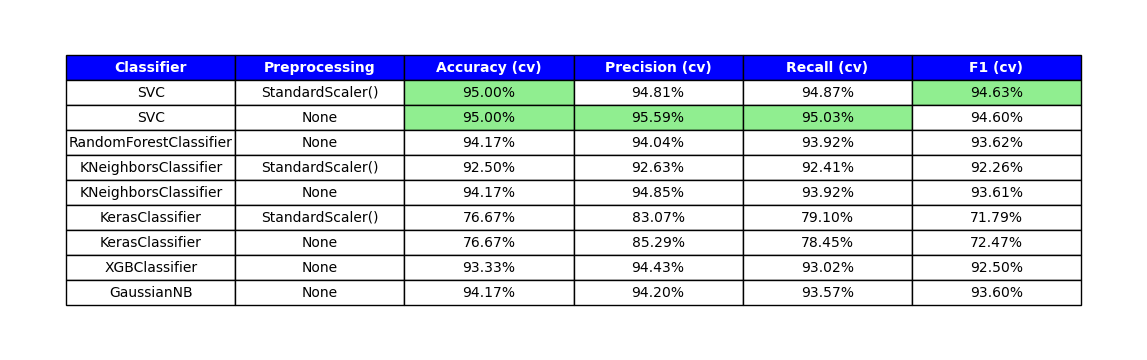

In [16]:
# Creating formatted results table 
fig, list_subfig = plt.subplots(figsize = (12,4))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)


table = list_subfig.table(cellText=df_results_table.values, 
                  colLabels=df_results_table.columns, 
                  loc='center', cellLoc='center')

table.scale(0.9, 1.5)  
list_subfig.axis('off')

# Highlighting  maximum values for each scoring metric
highlight_cols = ['Accuracy (cv)', 'Precision (cv)', 'Recall (cv)', 'F1 (cv)']
for col in highlight_cols:
    max_value = df_results_table[col].max()
    for (i, j), cell in table.get_celld().items():
        if i > 0 and j == df_results_table.columns.get_loc(col):  
            if df_results_table[col].iloc[i-1] == max_value:  
                cell.set_facecolor('lightgreen') 


# Formatting table
for (i, j), cell in table.get_celld().items():
    if i == 0:  
        cell.set_facecolor('blue')  
        cell.set_text_props(color='white', weight='bold', fontsize=10)  
    cell.set_edgecolor('black')  

table.auto_set_font_size(False)
table.set_fontsize(10) 

plt.show()

Findings:
- **SVC:** achieved the highest accuracy (95%) with minimal cross-validation error across all metrics, both with and without scaling
- **Random Forest:** performed slightly below SVC with 93.33% accuracy and low-cross validation errors 
- **k-NN:** surprisingly performed better without scaling, reaching 94.17% accuracy; cross-validation errors were low, but the inconsistent impact of scaling suggests that k-NN may not be as robust as SVC
- **Neural Network:** had higher cross-validation errors and lower overall performance (accuracy around 79% with scaling, 73% without), which suggests it may be too complex or insufficiently tuned for the dataset
- **XGBoost:** had similar results to Random Forest which slighly improved cross-validation errors on precision and recall
- **Gaussian Naive Bayes:** performed well at 94.17% accuracy with low cross-validation errors, despite the independence assumption; a good alternative to SVC for simplicity


I have decided to continue with SVC without scaling as it has the lowest cross-validation errors across all metrics except for F1 score, which is only marginally higher than the lowest error score:
- Cross-validation error for *accuracy:* 5.00%
- Cross-validation error for *precision:* 4.41%
- Cross-validation error for *recall:* 4.97%
- Cross-validation error for *F1:* 5.40%

## Tune Hyperparameters 

SVC has a number of hyperparameters that can be tuned. I have chosen to focus on the C (regularlization parameter), gamma (kernel coefficient), and kernel (type of kernel) because these provide the most control over the model's decision boundaries and complexity, helping to capture the sstructure of the small, relatively simple dataset effectively. The combination of these parameters will help me balance between simplicity and accuracy. 

In [17]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],           
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'] 
}

In [18]:
svc = SVC()

# Conducting grid search cross-validation with 5 folds 
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, return_train_score=True,
                           n_jobs=-1, scoring=scoring_metrics, refit=False) 

# Fitting the model on training data
grid_search.fit(X_train, y_train)

# Creating a dictionary to store best parameters for each metric
best_params = {}

# Extracting the best parameters for each scoring metric
for metric in scoring_metrics.keys():
    best_index = grid_search.cv_results_[f"mean_test_{metric}"].argmax()
    best_params[metric] = {
        "Best Parameters": grid_search.cv_results_["params"][best_index],
        "Best Score": grid_search.cv_results_[f"mean_test_{metric}"][best_index]
    }

# Displaying the best parameters for each metric
for metric, result in best_params.items():
    print(f"Best parameters for highest {metric}: {result['Best Parameters']}")
    print(f"Best cross-validation {metric.capitalize()}: {result['Best Score'] * 100:.2f}%\n")


Best parameters for highest accuracy: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation Accuracy: 95.83%

Best parameters for highest precision: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation Precision: 97.04%

Best parameters for highest recall: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation Recall: 95.83%

Best parameters for highest f1: {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}
Best cross-validation F1: 95.78%



Findings:
- When C = 0.1, gamma = 0.1, and kernel = poly:
    - The model achieves the highest cross-validation accuracy (and consequently, the lowest cross-validation accuracy error), meaning that, on average, it correctly classifies about 96% of the observations
    - The highest cross-validation precision is also achieved with this configuration, with a cross-validation precision error of just 2.96%, indicating the model is highly effective at minimizing false positives across classes 
    - Cross-validation recall is similarly optimized at ~96%, meaning the model successfully identifies a large portion of true positives, showing strong sensitivity across classes
- When C = 10, gamma = 0.01, and kernel = poly:
    - The highest cross-validation F1 score is achieved, suggesting this configuration might be more suitable in situations where balancing precision and recall is crucial


I have decided to set the parameter of my final model to C = 0.1, gamma = 0.1, and kernel = poly. This configuration yields the optimal balance between accuracy, precision, and recall, making it an effective choice for minimizing both misclassification rates and false positives, while also achieving high sensitivity across classes.

## Test Model

In [19]:
# Defining the final model with the above hyperparameters 
final_model = SVC(C=0.1, gamma=0.1, kernel='poly')

In [20]:
# Fitting the final model on the full training data set 
final_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='poly')

In [21]:
# Making predictions on the test dataset 
y_pred = final_model.predict(X_test)

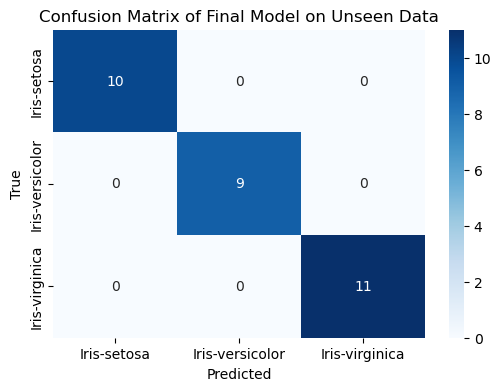

In [23]:
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

# Generate the confusion matrix with original labels
conf_matrix = confusion_matrix(y_test_original, y_pred_original)


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Final Model on Unseen Data')
plt.show()

In [24]:
# Calculating performance metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print(f"Test F1 Score: {test_f1 * 100:.2f}%")

Test Accuracy: 100.00%
Test Precision: 100.00%
Test Recall: 100.00%
Test F1 Score: 100.00%


Perfect evaluation scores were achieved on unseen test data, which makes me a bit apprehensive. The perfect scores could be due to the fact that the dataset has clear class separability and limited noise.

Findings:
- The high evaluation scores on the unseen test data suggest that the model generalizes well on this dataset 
- The hyperparameters C = 0.1, gamma = 0.1, and kernel = poly maximize the model's ability to capture the class boundaries without overfitting 